In [1]:
from config import *

from easyric.caas_lite import TiffSpliter
from easyric.objects import Pix4D
from easyric.io import shp, geotiff, plot
from easyric.calculate import geo2raw, geo2tiff

import os
import shapefile
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import shapely
import tifffile



In [2]:
import re
import pickle
import json
from scipy.spatial import KDTree
from easyric import caas_lite
import tifffile as tf
from skimage.transform import ProjectiveTransform
import random
from tqdm.notebook import tqdm

# data io

In [3]:
# read field measure data
destructive = pd.read_csv("out/destructive20.csv")
destructive

,date,Ground_ID,UAV_ID,flower_size_max,flower_size_min,weight
0,20200522,S30_01,4368.0,0.0,0.0,0.0
1,20200522,S30_02,4367.0,98.0,81.0,160.0
2,20200522,S30_03,4366.0,123.0,105.0,280.0
3,20200522,S30_04,4365.0,108.0,96.0,205.0
4,20200522,S30_05,4364.0,102.0,92.0,175.0
...,...,...,...,...,...,...
429,20200528,S41_67,5891.0,148.0,125.0,370.0
430,20200528,S41_68,5890.0,161.0,133.0,390.0
431,20200528,S41_69,5889.0,155.0,145.0,365.0
432,20200528,S41_70,5888.0,191.0,165.0,560.0


In [9]:
destructive = destructive[destructive.weight != 0]
destructive

,date,Ground_ID,UAV_ID,flower_size_max,flower_size_min,weight
1,20200522,S30_02,4367.0,98.0,81.0,160.0
2,20200522,S30_03,4366.0,123.0,105.0,280.0
3,20200522,S30_04,4365.0,108.0,96.0,205.0
4,20200522,S30_05,4364.0,102.0,92.0,175.0
5,20200522,S30_06,4363.0,116.0,114.0,235.0
...,...,...,...,...,...,...
429,20200528,S41_67,5891.0,148.0,125.0,370.0
430,20200528,S41_68,5890.0,161.0,133.0,390.0
431,20200528,S41_69,5889.0,155.0,145.0,365.0
432,20200528,S41_70,5888.0,191.0,165.0,560.0


In [4]:
pd.unique(destructive.date)

array([20200522, 20200526, 20200528])

In [6]:
# read uav data
uav_measured = pd.read_excel("out/2020_props_all.xlsx")
uav_measured

,date,label,area,convex_area,eccentricity,equivalent_diameter,major_axis_length,minor_axis_length,min_area_rect_max,min_area_rect_min,perimeter,circularity
0,20200520,292,1276,1344,0.816649,40.306993,54.129544,31.240005,53.331570,30.304739,148.953319,0.722704
1,20200520,1,3606,3709,0.519565,67.759145,73.503186,62.803382,69.652748,65.997498,231.722871,0.843913
2,20200520,148,4273,4434,0.678919,73.760102,87.082156,63.936849,82.405136,66.740005,265.421356,0.762204
3,20200520,293,5143,5282,0.449899,80.921388,85.785056,76.612857,83.176819,76.316864,279.906638,0.824898
4,20200520,2,4276,4490,0.520682,73.785990,80.426928,68.664528,77.712067,69.247444,263.036580,0.776632
...,...,...,...,...,...,...,...,...,...,...,...,...
35741,20200528,7546,17715,18221,0.501960,150.184681,161.953955,140.072502,159.028656,141.719421,517.872150,0.830053
35742,20200528,7116,19232,21152,0.509643,156.483044,171.425192,147.491877,169.115128,156.980820,589.126984,0.696332
35743,20200528,7406,17105,18040,0.639508,147.576294,169.656371,130.429146,163.861603,131.679733,538.901587,0.740140
35744,20200528,7262,14412,15958,0.695328,135.461907,163.834892,117.746931,162.350967,119.264641,516.073160,0.680004


In [7]:
uav_measured.replace([np.inf, -np.inf], np.nan, inplace=True)
uav_measured = uav_measured.dropna()
uav_measured

,date,label,area,convex_area,eccentricity,equivalent_diameter,major_axis_length,minor_axis_length,min_area_rect_max,min_area_rect_min,perimeter,circularity
0,20200520,292,1276,1344,0.816649,40.306993,54.129544,31.240005,53.331570,30.304739,148.953319,0.722704
1,20200520,1,3606,3709,0.519565,67.759145,73.503186,62.803382,69.652748,65.997498,231.722871,0.843913
2,20200520,148,4273,4434,0.678919,73.760102,87.082156,63.936849,82.405136,66.740005,265.421356,0.762204
3,20200520,293,5143,5282,0.449899,80.921388,85.785056,76.612857,83.176819,76.316864,279.906638,0.824898
4,20200520,2,4276,4490,0.520682,73.785990,80.426928,68.664528,77.712067,69.247444,263.036580,0.776632
...,...,...,...,...,...,...,...,...,...,...,...,...
35741,20200528,7546,17715,18221,0.501960,150.184681,161.953955,140.072502,159.028656,141.719421,517.872150,0.830053
35742,20200528,7116,19232,21152,0.509643,156.483044,171.425192,147.491877,169.115128,156.980820,589.126984,0.696332
35743,20200528,7406,17105,18040,0.639508,147.576294,169.656371,130.429146,163.861603,131.679733,538.901587,0.740140
35744,20200528,7262,14412,15958,0.695328,135.461907,163.834892,117.746931,162.350967,119.264641,516.073160,0.680004


In [12]:
pd.unique(uav_measured.date)

array([20200520, 20200522, 20200525, 20200526, 20200528])

In [11]:
# merge to training data
merged_pd = pd.merge(destructive[["date", "UAV_ID", "weight"]], uav_measured, left_on=["date", "UAV_ID"], right_on=["date","label"])
merged_pd

,date,UAV_ID,weight,label,area,convex_area,eccentricity,equivalent_diameter,major_axis_length,minor_axis_length,min_area_rect_max,min_area_rect_min,perimeter,circularity
0,20200528,6102.0,585.0,6102,21686,22694,0.414709,166.167003,175.646980,159.830674,169.494400,159.864044,590.884343,0.780521
1,20200528,6100.0,600.0,6100,22707,24209,0.561117,170.033674,189.269958,156.665691,182.600006,160.400009,626.925974,0.726001
2,20200528,6099.0,630.0,6099,19280,20625,0.707982,156.678200,189.757390,134.012488,184.803726,139.735779,584.984848,0.707991
3,20200528,6098.0,440.0,6098,15825,16502,0.289731,141.947229,146.795905,140.499545,149.000000,139.000000,508.759451,0.768296
4,20200528,6097.0,610.0,6097,21133,22846,0.515548,164.034665,180.101727,154.322094,176.214722,166.850220,601.570635,0.733834
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128,20200528,5891.0,370.0,5891,17326,18065,0.510853,148.526591,161.497481,138.834189,152.165894,143.013992,532.801082,0.766969
129,20200528,5890.0,390.0,5890,12920,14217,0.678575,128.258547,154.812616,113.714680,145.235016,119.054535,486.658946,0.685524
130,20200528,5889.0,365.0,5889,11215,13378,0.841931,119.496366,172.155411,92.892451,152.973984,103.007957,491.931024,0.582372
131,20200528,5888.0,560.0,5888,20136,21164,0.503347,160.118554,173.896665,150.261431,172.032867,149.322754,573.357431,0.769719


0522 & 0526 before dom is not good, so use after, but after has no destructive sampling data, so use a day before to have enough training data

In [55]:
destructive_alt = destructive[["date", "UAV_ID", "weight"]]
destructive_alt = destructive_alt.replace(20200526, 20200525)
destructive_alt = destructive_alt.replace(20200522, 20200520)
destructive_alt

,date,UAV_ID,weight
1,20200520,4367.0,160.0
2,20200520,4366.0,280.0
3,20200520,4365.0,205.0
4,20200520,4364.0,175.0
5,20200520,4363.0,235.0
...,...,...,...
429,20200528,5891.0,370.0
430,20200528,5890.0,390.0
431,20200528,5889.0,365.0
432,20200528,5888.0,560.0


In [56]:
pd.unique(destructive_alt.date)

array([20200520, 20200525, 20200528])

In [57]:
# merge to training data
merged_pd = pd.merge(destructive_alt, uav_measured, left_on=["date", "UAV_ID"], right_on=["date","label"])
merged_pd

,date,UAV_ID,weight,label,area,convex_area,eccentricity,equivalent_diameter,major_axis_length,minor_axis_length,min_area_rect_max,min_area_rect_min,perimeter,circularity,weight_pred
0,20200520,4367.0,160.0,4367,2409,2762,0.780338,55.382615,73.920209,46.226615,70.758057,47.809010,214.894444,0.655536,419.176014
1,20200520,4366.0,280.0,4366,5958,6240,0.585706,87.097424,97.887566,79.340201,93.761650,80.858055,308.048773,0.788990,314.159308
2,20200520,4365.0,205.0,4365,3601,3879,0.766923,67.712153,86.105662,55.257413,81.285629,55.841606,246.551299,0.744421,365.993848
3,20200520,4364.0,175.0,4364,3958,4076,0.436230,70.989310,75.319898,67.775490,71.941177,69.117645,246.450793,0.818889,212.981027
4,20200520,4363.0,235.0,4363,6511,6849,0.227907,91.049781,93.125755,90.674962,93.463242,92.374062,323.563492,0.781517,247.069377
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
407,20200528,5891.0,370.0,5891,17326,18065,0.510853,148.526591,161.497481,138.834189,152.165894,143.013992,532.801082,0.766969,470.813353
408,20200528,5890.0,390.0,5890,12920,14217,0.678575,128.258547,154.812616,113.714680,145.235016,119.054535,486.658946,0.685524,452.855993
409,20200528,5889.0,365.0,5889,11215,13378,0.841931,119.496366,172.155411,92.892451,152.973984,103.007957,491.931024,0.582372,474.234566
410,20200528,5888.0,560.0,5888,20136,21164,0.503347,160.118554,173.896665,150.261431,172.032867,149.322754,573.357431,0.769719,528.692873


# Auto sklearn

In [18]:
import autosklearn
import autosklearn.regression
import sklearn.model_selection
import sklearn.datasets
import sklearn.metrics

In [58]:
dataset = merged_pd.copy().drop(columns=["date", "UAV_ID", "label"])
dataset

,weight,area,convex_area,eccentricity,equivalent_diameter,major_axis_length,minor_axis_length,min_area_rect_max,min_area_rect_min,perimeter,circularity,weight_pred
0,160.0,2409,2762,0.780338,55.382615,73.920209,46.226615,70.758057,47.809010,214.894444,0.655536,419.176014
1,280.0,5958,6240,0.585706,87.097424,97.887566,79.340201,93.761650,80.858055,308.048773,0.788990,314.159308
2,205.0,3601,3879,0.766923,67.712153,86.105662,55.257413,81.285629,55.841606,246.551299,0.744421,365.993848
3,175.0,3958,4076,0.436230,70.989310,75.319898,67.775490,71.941177,69.117645,246.450793,0.818889,212.981027
4,235.0,6511,6849,0.227907,91.049781,93.125755,90.674962,93.463242,92.374062,323.563492,0.781517,247.069377
...,...,...,...,...,...,...,...,...,...,...,...,...
407,370.0,17326,18065,0.510853,148.526591,161.497481,138.834189,152.165894,143.013992,532.801082,0.766969,470.813353
408,390.0,12920,14217,0.678575,128.258547,154.812616,113.714680,145.235016,119.054535,486.658946,0.685524,452.855993
409,365.0,11215,13378,0.841931,119.496366,172.155411,92.892451,152.973984,103.007957,491.931024,0.582372,474.234566
410,560.0,20136,21164,0.503347,160.118554,173.896665,150.261431,172.032867,149.322754,573.357431,0.769719,528.692873


In [59]:
y = dataset.weight.to_numpy(dtype=int)

In [73]:
X = dataset.copy().drop(columns=["weight", "min_area_rect_max", "min_area_rect_min"]).to_numpy()
X.shape

(412, 8)

In [74]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, random_state=1)

In [75]:
X_train.shape

(309, 8)

In [76]:
automl = autosklearn.regression.AutoSklearnRegressor(
    time_left_for_this_task=120,
    per_run_time_limit=30,
    tmp_folder='/tmp/autosklearn_regression_broccoli20_tmp',
)

In [78]:
automl.fit(X_train, y_train, dataset_name='broccoli')

AutoSklearnRegressor(per_run_time_limit=30, time_left_for_this_task=120,
                     tmp_folder='/tmp/autosklearn_regression_broccoli20_tmp')

In [79]:
print(automl.leaderboard())

          rank  ensemble_weight              type      cost  duration
model_id                                                             
15           1             0.16               sgd  0.368215  0.455098
33           2             0.18               sgd  0.381109  0.435539
34           3             0.34  gaussian_process  0.381219  3.489987
4            4             0.18  gaussian_process  0.444570  1.620302
22           5             0.06     decision_tree  0.520551  0.408930
27           6             0.08  gaussian_process  0.534956  1.172121


In [80]:
train_predictions = automl.predict(X_train)
print("Train R2 score:", sklearn.metrics.r2_score(y_train, train_predictions))
test_predictions = automl.predict(X_test)
print("Test R2 score:", sklearn.metrics.r2_score(y_test, test_predictions))

Train R2 score: 0.8167005542794976
Test R2 score: 0.7641199875933078


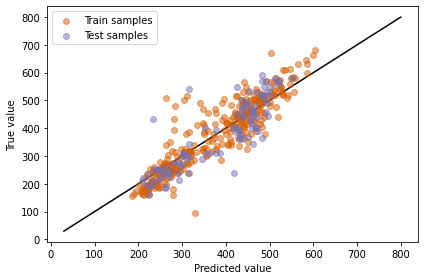

In [81]:
plt.scatter(train_predictions, y_train, label="Train samples", c='#d95f02', alpha=0.5)
plt.scatter(test_predictions, y_test, label="Test samples", c='#7570b3', alpha=0.5)
plt.xlabel("Predicted value")
plt.ylabel("True value")
plt.legend()
plt.plot([30, 800], [30, 800], c='k', zorder=0)
#plt.xlim([30, 400])
#plt.ylim([30, 400])
plt.tight_layout()
plt.show()

In [82]:
with open('out/automl20.pickle', 'wb') as handle:
    pickle.dump([automl, X_train, X_test, y_train, y_test], handle, protocol=pickle.HIGHEST_PROTOCOL)

## try to import 21 model 

In [83]:
with open('out/automl21.pickle', 'rb') as handle:
    automl21, _, _, _, _ = pickle.load(handle)

In [84]:
train_predictions = automl21.predict(X_train)
print("Train R2 score:", sklearn.metrics.r2_score(y_train, train_predictions))
test_predictions = automl21.predict(X_test)
print("Test R2 score:", sklearn.metrics.r2_score(y_test, test_predictions))

Train R2 score: 0.6391639554656631
Test R2 score: 0.7000930588348726


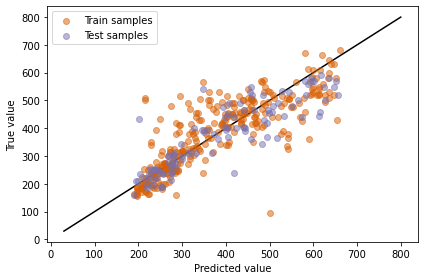

In [85]:
plt.scatter(train_predictions, y_train, label="Train samples", c='#d95f02', alpha=0.5)
plt.scatter(test_predictions, y_test, label="Test samples", c='#7570b3', alpha=0.5)
plt.xlabel("Predicted value")
plt.ylabel("True value")
plt.legend()
plt.plot([30, 800], [30, 800], c='k', zorder=0)
#plt.xlim([30, 400])
#plt.ylim([30, 400])
plt.tight_layout()
plt.show()

Failed

# Apply on full plot

In [89]:
X_full = uav_measured.copy().drop(columns=["date","label", "min_area_rect_max", "min_area_rect_min"]).to_numpy()
X_full.shape

(35743, 8)

In [90]:
W_predict = automl.predict(X_full)

In [91]:
import seaborn as sns

<AxesSubplot:ylabel='Density'>

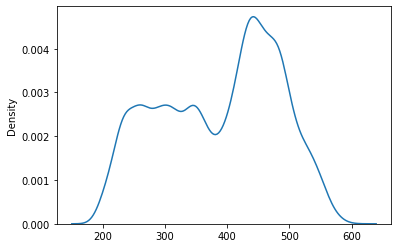

In [92]:
sns.kdeplot(x=W_predict)

In [93]:
uav_measured["weight_pred"] = W_predict
uav_measured

/tmp/ipykernel_2645/3352450077.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  uav_measured["weight_pred"] = W_predict


,date,label,area,convex_area,eccentricity,equivalent_diameter,major_axis_length,minor_axis_length,min_area_rect_max,min_area_rect_min,perimeter,circularity,weight_pred
0,20200520,292,1276,1344,0.816649,40.306993,54.129544,31.240005,53.331570,30.304739,148.953319,0.722704,260.504793
1,20200520,1,3606,3709,0.519565,67.759145,73.503186,62.803382,69.652748,65.997498,231.722871,0.843913,212.939606
2,20200520,148,4273,4434,0.678919,73.760102,87.082156,63.936849,82.405136,66.740005,265.421356,0.762204,229.137636
3,20200520,293,5143,5282,0.449899,80.921388,85.785056,76.612857,83.176819,76.316864,279.906638,0.824898,214.119175
4,20200520,2,4276,4490,0.520682,73.785990,80.426928,68.664528,77.712067,69.247444,263.036580,0.776632,228.804268
...,...,...,...,...,...,...,...,...,...,...,...,...,...
35741,20200528,7546,17715,18221,0.501960,150.184681,161.953955,140.072502,159.028656,141.719421,517.872150,0.830053,411.367273
35742,20200528,7116,19232,21152,0.509643,156.483044,171.425192,147.491877,169.115128,156.980820,589.126984,0.696332,510.048788
35743,20200528,7406,17105,18040,0.639508,147.576294,169.656371,130.429146,163.861603,131.679733,538.901587,0.740140,474.659117
35744,20200528,7262,14412,15958,0.695328,135.461907,163.834892,117.746931,162.350967,119.264641,516.073160,0.680004,508.702234


<AxesSubplot:xlabel='weight_pred', ylabel='Density'>

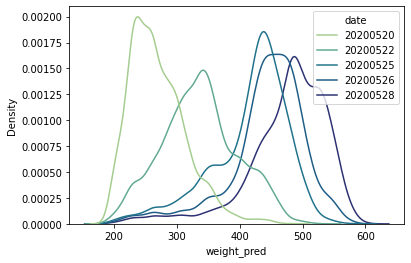

In [94]:
sns.kdeplot(data=uav_measured, x="weight_pred", hue="date", palette="crest")

In [95]:
uav_measured.to_excel("out/2020_measured_weight.xlsx", index=False)